Import block and functions definition


In [ ]:
import os
import urllib.request
import bz2
import dlib
import cv2
import numpy as np
import pandas as pd
import scipy.ndimage
import matplotlib.pyplot as plt

from scipy.ndimage import median_filter
from matplotlib import patches
from pathlib import Path
from skimage.io import imread
from skimage import data,io, color,transform,feature
from skimage.filters import butterworth
from skimage.feature import Cascade,graycomatrix, graycoprops
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score,confusion_matrix
from google.colab.patches import cv2_imshow

from google.colab import drive
drive.mount('/content/drive')

# Load Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

#Load the trained file from module root
trained_file = data.lbp_frontal_face_cascade_filename()
# Initialize the detector cascade.
detector = Cascade(trained_file)

#Method to download the landmark model to detect face eith head pose method.
def download_landmark_model():
  if not os.path.exists('shape_predictor_68_face_landmarks.dat'):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    urllib.request.urlretrieve(url, 'shape_predictor_68_face_landmarks.dat.bz2')

    with bz2.BZ2File('shape_predictor_68_face_landmarks.dat.bz2') as fr, open('shape_predictor_68_face_landmarks.dat', 'wb') as fw:
        fw.write(fr.read())

def eye_extraction(image_path,output_folder_R,output_folder_L):

  # Download landmark model if is not present
  download_landmark_model()
  # Load dlib face detetctor
  detector = dlib.get_frontal_face_detector()
  # Load face landmark predictor
  predictor_path = 'shape_predictor_68_face_landmarks.dat'
  predictor = dlib.shape_predictor(predictor_path)

  if not os.path.exists(output_folder_R):
    os.makedirs(output_folder_R)

  if not os.path.exists(output_folder_L):
    os.makedirs(output_folder_L)

  # Load image
  img = cv2.imread(image_path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Detect faces
  faces = detector(img, 1)
  landmarks = None

  # If we detect a face, we compute landmarks
  if len(faces) > 0:
    shape = predictor(img,faces[0])
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])

  if landmarks is None:
    print(f"No face detected in {image_path}.")
    return None, None


  # Eyes landmarks
  left_eye_landmarks = landmarks[36:42]  # Points from 36 to 41
  right_eye_landmarks = landmarks[42:48] # Points from 42 to 47

  # Found left eye rectangle
  left_eye_rect = cv2.boundingRect(left_eye_landmarks)
  x_left, y_left, w_left, h_left = left_eye_rect

  # Find right eye rectangle
  right_eye_rect = cv2.boundingRect(right_eye_landmarks)
  x_right, y_right, w_right, h_right = right_eye_rect

  margin = 20

  # Eye images extraction with rectangle borders
  left_eye_image = img_rgb[(y_left-margin):y_left+h_left+margin, (x_left-margin):x_left+w_left+margin]
  right_eye_image = img_rgb[(y_right-margin):y_right+h_right+margin, (x_right-margin):x_right+w_right+margin]

  # We save extracted eyes in a new image, to speed up the process.
  output_path_R = os.path.join(output_folder_R, f"Right_eye_{os.path.basename(image_path)}")
  io.imsave(output_path_R, right_eye_image)
  print(f"Saved face in: {output_path_R}")

  output_path_L = os.path.join(output_folder_L, f"left_eye_{os.path.basename(image_path)}")
  io.imsave(output_path_L, left_eye_image)
  print(f"Saved face in: {output_path_L}")

  return left_eye_image,right_eye_image

# We define the

distances = [1,8,16,32]  # Distances between pixels.
angles = [0, np.pi/2]    # angle directions.
LP_filter = (1/4)*np.array([[0, 1, 0],[1, 0, 1],[0, 1, 0]]) # Low-pass filter

def compute_Feature(input_image, filter_name = None):

  # GLCM properties computation for images
  img = io.imread(input_image)

  # Apply Filter if specified
  if filter_name:
    img = apply_filter(img, filter_name)

  # Gray image conversion
  gray_input_image = color.rgb2gray(img)
  # unsigned integer conversion
  gray_input_image = (gray_input_image * 255).astype(np.uint8)
  LP_filtered_img = scipy.ndimage.convolve(gray_input_image, LP_filter)

  HP_filtered_img = gray_input_image - LP_filtered_img

  glcm = graycomatrix(HP_filtered_img, distances=distances, angles=angles,levels=256, symmetric=True, normed=True)

  # GLCM properties extraction
  energy = feature.graycoprops(glcm, 'energy').flatten()
  contrast = feature.graycoprops(glcm, 'contrast').flatten()
  dissimilarity = feature.graycoprops(glcm, 'dissimilarity').flatten()
  correlation = feature.graycoprops(glcm, 'correlation').flatten()
  homogeneity = feature.graycoprops(glcm, 'homogeneity').flatten()

  # Save computed properties in an array.
  return np.concatenate([energy,contrast,dissimilarity,correlation,homogeneity])

def compute_mean_GLCM_values(array1,array2):

  if len(array1) != len(array2):
    raise ValueError("Featutes must have same lenght")

  # Compute mean values between left eye and right eye.
  mean_values = (array1 + array2) / 2.0

  return mean_values

def prepare_dataset_csv_eyes(real_left_eye_folder,real_right_eye_folder,fake_left_eye_folder,fake_right_eye_folder,output_csv):
  data = []
  labels = []

  #process real images and save features in CSV file.
  for i,n in enumerate(os.listdir(real_left_eye_folder)):
    left_eye_img = os.listdir(real_left_eye_folder)[i]
    right_eye_img = os.listdir(real_right_eye_folder)[i]

    feature_left_eye = compute_Feature(real_left_eye_folder + "/" + left_eye_img, 'gaussian')
    feature_right_eye = compute_Feature(real_right_eye_folder + "/" + right_eye_img,'gaussian')
    # we use mean values between left and right eye.
    mean_eyes_feature = compute_mean_GLCM_values(feature_left_eye,feature_right_eye)
    data.append([f"eyes_real_img{i+1}"] + list(mean_eyes_feature) + [1])

    print("processata img: " + left_eye_img)

  #process fake images and save features in CSV file.
  for i,n in enumerate(os.listdir(fake_left_eye_folder)):
    left_eye_img = os.listdir(fake_left_eye_folder)[i]
    right_eye_img = os.listdir(fake_right_eye_folder)[i]

    feature_left_eye = compute_Feature(fake_left_eye_folder + "/" + left_eye_img, 'gaussian')
    feature_right_eye = compute_Feature(fake_right_eye_folder + "/" + right_eye_img, 'gaussian')

    mean_eyes_feature = compute_mean_GLCM_values(feature_left_eye, feature_right_eye)

    data.append([f"eyes_fake_img{i+1}"] + list(mean_eyes_feature) + [0])

    print("processed img: " + left_eye_img)

  # convert to DataFrame
  '''
  df = pd.DataFrame(data,columns = ['Image_Name', 'Energy_0','Energy_π/4','Energy_π/2','Energy_3π/4',
                                     'Contrast_0','Contrast_π/4','Contrast_π/2','Contrast_3π/4',
                                     'Dissimilarity_0','Dissimilarity_π/4','Dissimilarity_π/2','Dissimilarity_3π/4',
                                     'Correlation_0','Correlation_π/4','Correlation_π/2','Correlation_3π/4',
                                     'Homogeneity_0','Homogeneity_π/4','Homogeneity_π/2','Homogeneity_3π/4','Label'])
  '''
  # these are the properties we want to analyze. We create a complete csv where
  # we are able to pull out the properties we need.

  df = pd.DataFrame(data,columns = ['Image_Name',
                                    'Energy_1_0','Energy_1_π/2','Energy_8_0','Energy_8_π/2','Energy_16_0','Energy_16_π/2','Energy_32_0','Energy_32_π/2',
                                    'Contrast_1_0','Contrast_1_π/2','Contrast_8_0','Contrast_8_π/2','Contrast_16_0','Contrast_16_π/2','Contrast_32_0','Contrast_32_π/2',
                                    'Dissimilarity_1_0','Dissimilarity_1_π/2','Dissimilarity_8_0','Dissimilarity_8_π/2','Dissimilarity_16_0','Dissimilarity_16_π/2','Dissimilarity_32_0','Dissimilarity_32_π/2',
                                    'Correlation_1_0','Correlation_1_π/2','Correlation_8_0','Correlation_8_π/2','Correlation_16_0','Correlation_16_π/2','Correlation_32_0','Correlation_32_π/2',
                                    'Homogeneity_1_0','Homogeneity_1_π/2','Homogeneity_8_0','Homogeneity_8_π/2','Homogeneity_16_0','Homogeneity_16_π/2','Homogeneity_32_0','Homogeneity_32_π/2',
                                    'Label'])

  # save to CSV
  df.to_csv(output_csv, index = False)

# method to create csv file.
def prepare_dataset_csv_faces(real_image_folder,fake_image_folder, output_csv):
  data = []
  labels = []

  #process real images and save features in CSV file.
  for i,n in enumerate(os.listdir(real_image_folder)):
    current_real_image = os.listdir(real_image_folder)[i]
    feature_current_real_image = compute_Feature(real_image_folder + "/" + current_real_image,'gaussian')
    data.append([current_real_image] + list(feature_current_real_image) + [1])
    print("processata img: " + current_real_image)

  #process fake images and save features in CSV file.
  for i,n in enumerate (os.listdir(fake_image_folder)):
    current_fake_image = os.listdir(fake_image_folder)[i]
    feature_current_fake_image = compute_Feature(fake_image_folder + "/" + current_fake_image,'gaussian')
    data.append([current_fake_image] + list(feature_current_fake_image) + [0])
    print("processata img: "+ current_fake_image)


   # convert to DataFrame
  df = pd.DataFrame(data,columns = ['Image_Name',
                                    'Energy_1_0','Energy_1_π/2','Energy_8_0','Energy_8_π/2','Energy_16_0','Energy_16_π/2','Energy_32_0','Energy_32_π/2',
                                    'Contrast_1_0','Contrast_1_π/2','Contrast_8_0','Contrast_8_π/2','Contrast_16_0','Contrast_16_π/2','Contrast_32_0','Contrast_32_π/2',
                                    'Dissimilarity_1_0','Dissimilarity_1_π/2','Dissimilarity_8_0','Dissimilarity_8_π/2','Dissimilarity_16_0','Dissimilarity_16_π/2','Dissimilarity_32_0','Dissimilarity_32_π/2',
                                    'Correlation_1_0','Correlation_1_π/2','Correlation_8_0','Correlation_8_π/2','Correlation_16_0','Correlation_16_π/2','Correlation_32_0','Correlation_32_π/2',
                                    'Homogeneity_1_0','Homogeneity_1_π/2','Homogeneity_8_0','Homogeneity_8_π/2','Homogeneity_16_0','Homogeneity_16_π/2','Homogeneity_32_0','Homogeneity_32_π/2',
                                    'Label'])

  """
  df = pd.DataFrame(data,columns = ['Image_Name', 'Energy_0','Energy_π/4','Energy_π/2','Energy_3π/4',
                                     'Contrast_0','Contrast_π/4','Contrast_π/2','Contrast_3π/4',
                                     'Dissimilarity_0','Dissimilarity_π/4','Dissimilarity_π/2','Dissimilarity_3π/4',
                                     'Correlation_0','Correlation_π/4','Correlation_π/2','Correlation_3π/4',
                                     'Homogeneity_0','Homogeneity_π/4','Homogeneity_π/2','Homogeneity_3π/4','Label'])
                                     """

  # save to CSV
  df.to_csv(output_csv, index = False)

def apply_median_filter(image):
    return median_filter(image, size=3)

def apply_gaussian_filter(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_laplacian_filter(image):
    return cv2.Laplacian(image, cv2.CV_64F)

def apply_mean_filter(image):
    return cv2.blur(image, (5, 5))

def apply_filter(image, filter_name):
    # Filters dictionary
    filters = {
        'median': apply_median_filter,
        'gaussian': apply_gaussian_filter,
        'laplacian': apply_laplacian_filter,
        'mean': apply_mean_filter,
    }

    if filter_name in filters:
        return filters[filter_name](image)
    else:
        raise ValueError("Filtro non supportato. Scegli tra: 'median', 'gaussian', 'laplacian', 'mean")






Computing Fatures and saving CVS File for Eyes

In [ ]:
real_left_eye_folder = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Training/Real/Left"
real_right_eye_folder = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Training/Real/Right"
fake_left_eye_folder = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Training/Fake/Left"
fake_right_eye_folder = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Training/Fake/Right"
output_csv = "/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Eyes/Training/Training_Features_Distances_Gaussian.csv"

prepare_dataset_csv_eyes(real_left_eye_folder,real_right_eye_folder,fake_left_eye_folder,fake_right_eye_folder,output_csv)


processata img: left_eye_real_img1.jpg
processata img: left_eye_real_img2.jpg
processata img: left_eye_real_img3.jpg
processata img: left_eye_real_img4.jpg
processata img: left_eye_real_img5.jpg
processata img: left_eye_real_img6.jpg
processata img: left_eye_real_img7.jpg
processata img: left_eye_real_img8.jpg
processata img: left_eye_real_img9.jpg
processata img: left_eye_real_img10.jpg
processata img: left_eye_real_img11.jpg
processata img: left_eye_real_img12.jpg
processata img: left_eye_real_img13.jpg
processata img: left_eye_real_img14.jpg
processata img: left_eye_real_img15.jpg
processata img: left_eye_real_img16.jpg
processata img: left_eye_real_img17.jpg
processata img: left_eye_real_img18.jpg
processata img: left_eye_real_img19.jpg
processata img: left_eye_real_img20.jpg
processata img: left_eye_real_img21.jpg
processata img: left_eye_real_img22.jpg
processata img: left_eye_real_img23.jpg
processata img: left_eye_real_img24.jpg
processata img: left_eye_real_img25.jpg
processat

Computing Fatures and saving CVS File for Faces

In [ ]:
real_image_directory = "/content/drive/MyDrive/Maestria/Capstone/Faces/Training/Real"
fake_image_directory = "/content/drive/MyDrive/Maestria/Capstone/Faces/Training/Fake"
output_csv = "/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Faces/Training/Training_Features_Distances_Gaussian.csv"

prepare_dataset_csv_faces(real_image_directory,fake_image_directory,output_csv)

processata img: face_real_img1.jpg
processata img: face_real_img2.jpg
processata img: face_real_img3.jpg
processata img: face_real_img4.jpg
processata img: face_real_img5.jpg
processata img: face_real_img6.jpg
processata img: face_real_img7.jpg
processata img: face_real_img8.jpg
processata img: face_real_img9.jpg
processata img: face_real_img10.jpg
processata img: face_real_img11.jpg
processata img: face_real_img12.jpg
processata img: face_real_img13.jpg
processata img: face_real_img14.jpg
processata img: face_real_img15.jpg
processata img: face_real_img16.jpg
processata img: face_real_img17.jpg
processata img: face_real_img18.jpg
processata img: face_real_img19.jpg
processata img: face_real_img20.jpg
processata img: face_real_img21.jpg
processata img: face_real_img22.jpg
processata img: face_real_img23.jpg
processata img: face_real_img24.jpg
processata img: face_real_img25.jpg
processata img: face_real_img26.jpg
processata img: face_real_img27.jpg
processata img: face_real_img28.jpg
p

Code block to train SVM model.

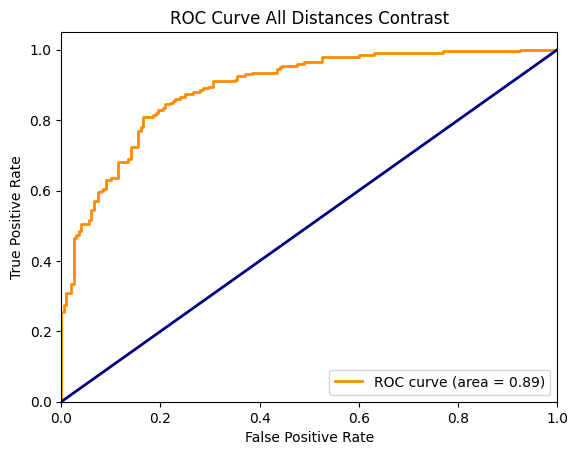

Valor del AUC: 0.891
Accuracy: 81.250%


'\n# Generare il report di classificazione\nreport = classification_report(y_test, svm.predict(X_test))\nprint("Classification Report:")\nprint(report)\n'

In [ ]:

from scipy.special import logit
from scipy.stats import gaussian_kde

#load data from csv file
train_df = pd.read_csv("/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Eyes/Training/Training_Features_Distances_Median.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Eyes/Testing/Testing_Features_Distances_Median.csv")

output_path = '/content/drive/MyDrive/Maestria/Capstone/Graphs/Face/Histogram/Histogram_0.pdf'

"""
'Energy_1_0','Energy_1_π/2','Energy_8_0','Energy_8_π/2','Energy_16_0','Energy_16_π/2','Energy_32_0','Energy_32_π/2',
'Contrast_1_0','Contrast_1_π/2','Contrast_8_0','Contrast_8_π/2','Contrast_16_0','Contrast_16_π/2','Contrast_32_0','Contrast_32_π/2',
'Dissimilarity_1_0','Dissimilarity_1_π/2','Dissimilarity_8_0','Dissimilarity_8_π/2','Dissimilarity_16_0','Dissimilarity_16_π/2','Dissimilarity_32_0','Dissimilarity_32_π/2',
'Correlation_1_0','Correlation_1_π/2','Correlation_8_0','Correlation_8_π/2','Correlation_16_0','Correlation_16_π/2','Correlation_32_0','Correlation_32_π/2',
'Homogeneity_1_0','Homogeneity_1_π/2','Homogeneity_8_0','Homogeneity_8_π/2','Homogeneity_16_0','Homogeneity_16_π/2','Homogeneity_32_0','Homogeneity_32_π/2'

'Energy_0','Energy_π/4','Energy_π/2','Energy_3π/4',
'Contrast_0','Contrast_π/4','Contrast_π/2','Contrast_3π/4',
'Dissimilarity_0','Dissimilarity_π/4','Dissimilarity_π/2','Dissimilarity_3π/4',
'Correlation_0','Correlation_π/4','Correlation_π/2','Correlation_3π/4',
'Homogeneity_0','Homogeneity_π/4','Homogeneity_π/2','Homogeneity_3π/4'
"""

selected_features = ['Energy_1_0','Energy_1_π/2','Energy_8_0','Energy_8_π/2','Energy_16_0','Energy_16_π/2','Energy_32_0','Energy_32_π/2',
                    #'Contrast_1_0','Contrast_1_π/2','Contrast_8_0','Contrast_8_π/2','Contrast_16_0','Contrast_16_π/2','Contrast_32_0','Contrast_32_π/2',
                    'Dissimilarity_1_0','Dissimilarity_1_π/2','Dissimilarity_8_0','Dissimilarity_8_π/2','Dissimilarity_16_0','Dissimilarity_16_π/2','Dissimilarity_32_0','Dissimilarity_32_π/2',
                    'Correlation_1_0','Correlation_1_π/2','Correlation_8_0','Correlation_8_π/2','Correlation_16_0','Correlation_16_π/2','Correlation_32_0','Correlation_32_π/2',
                    'Homogeneity_1_0','Homogeneity_1_π/2','Homogeneity_8_0','Homogeneity_8_π/2','Homogeneity_16_0','Homogeneity_16_π/2','Homogeneity_32_0','Homogeneity_32_π/2'
                    ]



filter = {'None','Median', 'Gaussian', 'Laplacian', }

# separate features from labels
X_train = train_df[selected_features]
y_train = train_df['Label']

X_test = test_df[selected_features]
y_test = test_df['Label']

#Train SVM model
svm = SVC(kernel="linear", probability=True)
svm.fit(X_train,y_train)

#predizione sui dati di test
y_pred_prob = svm.predict_proba(X_test)[:, 1]

'''
decision_scores = svm.decision_function(X_test)

# Convertir los puntajes de decisión a probabilidades
probabilities = 1 / (1 + np.exp(-decision_scores))

# Aplicar la transformación logit a las probabilidades
logit_scores = logit(probabilities)

# Separar los logit scores por clase
logit_scores_real = logit_scores[y_test == 1]
logit_scores_fake = logit_scores[y_test == 0]

# Graficar el histograma de los logit scores por separado

colors = ['#6d98ba', '#FFA245']  # Blue for real, Orange for fake

plt.figure(figsize=(12, 6))

plt.hist(logit_scores_real, bins=50, alpha=0.5, label='Real', color=colors[0], density=True)
plt.hist(logit_scores_fake, bins=50, alpha=0.5, label='Fake', color=colors[1], density=True)

kde_real = gaussian_kde(logit_scores_real)
x_real = np.linspace(logit_scores_real.min(), logit_scores_real.max(), 1000)
plt.plot(x_real, kde_real(x_real), color=colors[0], linestyle='-', linewidth=2)


kde_real = gaussian_kde(logit_scores_fake)
x_fake = np.linspace(logit_scores_fake.min(), logit_scores_fake.max(), 1000)
plt.plot(x_fake, kde_real(x_fake), color=colors[1], linestyle='-', linewidth=2)

plt.xlabel('Logit Score')
plt.ylabel('Density')
plt.legend()
plt.grid(False)
plt.savefig(output_path, format='jpg')
plt.show()
'''

# Calcolare i valori per la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Disegnare la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='-')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve All Distances Contrast')
plt.legend(loc='lower right')

plt.show()
plt.close()

# Calcolare l'accuratezza
print(f'Valor del AUC: {roc_auc:.3f}')
accuracy = accuracy_score(y_test, svm.predict(X_test))
print(f'Accuracy: {accuracy * 100:.3f}%')


"""
# Generare il report di classificazione
report = classification_report(y_test, svm.predict(X_test))
print("Classification Report:")
print(report)
"""



Histograms Computation after classification

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from typing import List


def plot_histograms_from_csv(traning, testing, output_path:str,angle_prefix) -> None:
  """
  Plot histograms for each angle column in the CSV file.

  Args:
  - file_name (str): Name of the CSV file.
  - angle_prefix (str): Prefix of the angle columns to identify them.
  """
  # Load the data
  df1 = pd.read_csv(traning)
  df2 = pd.read_csv(testing)

  # Concatenate data frames
  data = pd.concat([df1, df2], axis=0, ignore_index=True)

  # Identify angle columns
  angle_columns = [col for col in data.columns if col.startswith(angle_prefix)]

  # Separate the data into real and fake groups
  real_data = data[data['Label'] == 1]
  fake_data = data[data['Label'] == 0]

  colors = ['#6d98ba', '#FFA245']  # Blue for real, Orange for fake

  num_columns = len(angle_columns)

  # Create a figure and subplots
  fig, axs = plt.subplots(1, num_columns, figsize=(5 * num_columns, 5), constrained_layout=True)

  # Plot histograms with trend lines
  for i, angle in enumerate(angle_columns):
    if i==0: name = "0 rad"
    if i==1: name = "$π/4$ rad"
    if i==2: name = "$π/2$ rad"
    if i==3: name = "$3π/4$ rad"

    ax = axs[i]

    # Histogram for real data
    real_values = real_data[angle]
    ax.hist(real_values, bins=50, alpha=0.5, label='Real', color=colors[0], density=True)

    # KDE for real data
    kde_real = gaussian_kde(real_values)
    x_real = np.linspace(real_values.min(), real_values.max(), 1000)
    ax.plot(x_real, kde_real(x_real), color=colors[0], linestyle='-',linewidth=3)

    # Histogram for fake data
    fake_values = fake_data[angle]
    ax.hist(fake_values, bins=50, alpha=0.5, label='Fake', color=colors[1], density=True)

    # KDE for fake data
    kde_fake = gaussian_kde(fake_values)
    x_fake = np.linspace(fake_values.min(), fake_values.max(), 1000)
    ax.plot(x_fake, kde_fake(x_fake), color=colors[1], linestyle='-',linewidth=3)

    ax.set_title(f'Histogram for {name}')
    ax.set_xlabel(angle_prefix)
    ax.set_ylabel('Density')
    ax.legend()

  #plt.savefig(output_path, format='pdf')

  plt.show()

# changing csv file paths it's possible to plot different properties or parameters.
training_path = "/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Faces/Training/Training_Features_Angles_1.csv"
testing_path = "/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Faces/Training/Training_Features_Angles_1.csv"
output_path = '/content/drive/MyDrive/Maestria/Capstone/Graphs/Faces/Histograms/Histogram_Dissimilarity_.pdf'

plot_histograms_from_csv(training_path, testing_path, output_path,'Dissimilarity')


Code block to train and compare different types of classifiers.

Valor AUC SVM: 0.949
Accuracy SVM: 65.750%
Valor AUC KNN: 0.901
Accuracy KNN: 65.750%
Valor AUC Random Forest: 0.952
Accuracy Random Forest: 65.750%
Valor AUC Logistic Regression: 0.951
Accuracy Logistic Regression: 65.750%
Valor AUC Naive Bayes: 0.727
Accuracy Naive Bayes: 65.750%


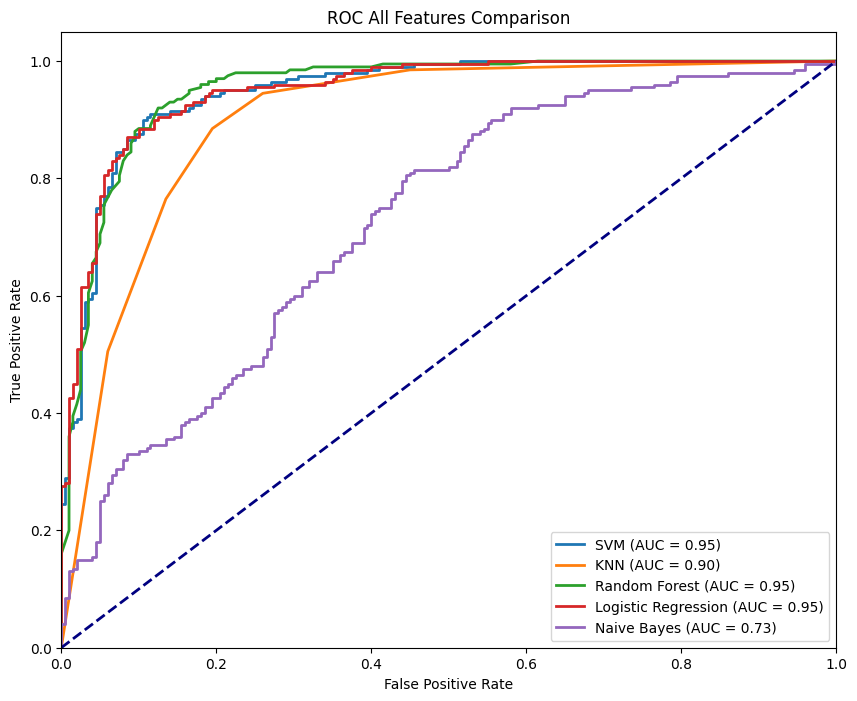

In [ ]:
#load data from csv file
train_df = pd.read_csv("/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Faces/Training/Training_Features_Distances_Filtered.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Faces/Testing/Testing_Features_Distances_Filtered.csv")

"""
'Energy_1_0','Energy_1_π/2','Energy_8_0','Energy_8_π/2','Energy_16_0','Energy_16_π/2','Energy_32_0','Energy_32_π/2',
'Contrast_1_0','Contrast_1_π/2','Contrast_8_0','Contrast_8_π/2','Contrast_16_0','Contrast_16_π/2','Contrast_32_0','Contrast_32_π/2',
'Dissimilarity_1_0','Dissimilarity_1_π/2','Dissimilarity_8_0','Dissimilarity_8_π/2','Dissimilarity_16_0','Dissimilarity_16_π/2','Dissimilarity_32_0','Dissimilarity_32_π/2',
'Correlation_1_0','Correlation_1_π/2','Correlation_8_0','Correlation_8_π/2','Correlation_16_0','Correlation_16_π/2','Correlation_32_0','Correlation_32_π/2',
'Homogeneity_1_0','Homogeneity_1_π/2','Homogeneity_8_0','Homogeneity_8_π/2','Homogeneity_16_0','Homogeneity_16_π/2','Homogeneity_32_0','Homogeneity_32_π/2',

"""

selected_features = ['Energy_1_0','Energy_1_π/2','Energy_8_0','Energy_8_π/2','Energy_16_0','Energy_16_π/2','Energy_32_0','Energy_32_π/2',
'Contrast_1_0','Contrast_1_π/2','Contrast_8_0','Contrast_8_π/2','Contrast_16_0','Contrast_16_π/2','Contrast_32_0','Contrast_32_π/2',
'Dissimilarity_1_0','Dissimilarity_1_π/2','Dissimilarity_8_0','Dissimilarity_8_π/2','Dissimilarity_16_0','Dissimilarity_16_π/2','Dissimilarity_32_0','Dissimilarity_32_π/2',
'Correlation_1_0','Correlation_1_π/2','Correlation_8_0','Correlation_8_π/2','Correlation_16_0','Correlation_16_π/2','Correlation_32_0','Correlation_32_π/2',
'Homogeneity_1_0','Homogeneity_1_π/2','Homogeneity_8_0','Homogeneity_8_π/2','Homogeneity_16_0','Homogeneity_16_π/2','Homogeneity_32_0','Homogeneity_32_π/2']

# separate features from labels
X_train = train_df[selected_features]
y_train = train_df['Label']

X_test = test_df[selected_features]
y_test = test_df['Label']

models = {
  'SVM': SVC(kernel = 'linear',probability= True),
  'KNN': KNeighborsClassifier(),
  'Random Forest': RandomForestClassifier(n_estimators = 100),
  'Logistic Regression': LogisticRegression(max_iter=10000),
  'Naive Bayes': GaussianNB()
}

#dictionary results creation.
results = {}

for name, model in models.items():
  model.fit(X_train,y_train)
  y_pred_prob = model.predict_proba(X_test)[:, 1]
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  auc_score = roc_auc_score(y_test, y_pred_prob)
  accuracy = accuracy_score(y_test, model.predict(X_test))

  results[name] = {
    'y_pred_prob': y_pred_prob,
    'fpr': fpr,
    'tpr': tpr,
    'auc': auc_score,
    'accuracy': accuracy
  }

# Disegnare le ROC curve per confronto
plt.figure(figsize=(10, 8))

for name, result in results.items():
  fpr = result['fpr']
  tpr = result['tpr']
  auc_score = result['auc']
  accu = result['accuracy']
  print(f'Valor AUC {name}: {auc_score:.3f}')
  print(f'Accuracy {name}: {accu * 100:.3f}%')
  plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC All Features Comparison')
plt.legend(loc='lower right')


# Salvare la ROC curve come PDFd
plt.savefig('/content/drive/MyDrive/Maestria/Capstone/Graphs/Face/ROC_Classifier_Comparison.pdf', format='pdf')

#plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from typing import List

def plot_histograms_from_csv(file_path: str, angle_prefix: str)-> None:
  """
  Plot histograms for each angle column in the CSV file.

  Args:
  - file_name (str): Name of the CSV file.
  - angle_prefix (str): Prefix of the angle columns to identify them.
  """
  # Load the data

  data = pd.read_csv(file_path)

  # Identify angle columns
  angle_columns = [col for col in data.columns if col.startswith(angle_prefix)]

  # Separate the data into real and fake groups
  real_data = data[data['Label'] == 1]
  fake_data = data[data['Label'] == 0]

  #colors = ['blue', 'orange']  # Blue for real, Orange for fake
  colors = ['#6d98ba', '#FFA245']

  # Create figures with 4 subplots each
  for i in range(0, len(angle_columns), 4):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    for j in range(4):
      if i + j < len(angle_columns):
        angle = angle_columns[i + j]

        # Histogram for real data
        real_values = real_data[angle]
        axs[j].hist(real_values, bins=50, alpha=0.5, label='Real', color=colors[0], density=True)

        # KDE for real data
        kde_real = gaussian_kde(real_values)
        x_real = np.linspace(real_values.min(), real_values.max(), 1000)
        axs[j].plot(x_real, kde_real(x_real), color=colors[0], linestyle='--')

        # Histogram for fake data
        fake_values = fake_data[angle]
        axs[j].hist(fake_values, bins=30, alpha=0.5, label='Fake', color=colors[1], density=True)

        # KDE for fake data
        kde_fake = gaussian_kde(fake_values)
        x_fake = np.linspace(fake_values.min(), fake_values.max(), 1000)
        axs[j].plot(x_fake, kde_fake(x_fake), color=colors[1], linestyle='--')

        axs[j].set_title(f'Histogram for {angle}')
        axs[j].set_xlabel(angle_prefix)
        axs[j].set_ylabel('Density')
        axs[j].legend()

    plt.tight_layout()
    plt.show()

    plt.savefig('/content/drive/MyDrive/Maestria/Capstone/Graphs/Eyes/Histogram_Energy.pdf', format='pdf')

# Example usage:
file_path = '/content/drive/MyDrive/Maestria/Capstone/CSV_Files/Faces/Training/Training_Features_Angles_Filtered.csv'

plot_histograms_from_csv(file_path, 'Homogeneity')


Saving eyes Images

In [ ]:
"""# --- Saving Fake Eyes images
image_directory_fake ="/content/drive/MyDrive/Maestria/Capstone/Training/Fake"
output_folder_R = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Fake/Right"
output_folder_L = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Fake/Left"

for i,n in enumerate(os.listdir(image_directory_fake)):
  image_path = os.listdir(image_directory_fake)[i]
  #print(image_directory_fake +"/"+ image_path)
  eye_extraction(image_directory_fake +"/"+ image_path,output_folder_R,output_folder_L)

"""
# --- Saving Real Eyes images
image_directory_real ="/content/drive/MyDrive/Maestria/Capstone/Training/Real"
output_folder_R = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Right"
output_folder_L = "/content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Left"
for i,n in enumerate(os.listdir(image_directory_real)):
  image_path = os.listdir(image_directory_real)[i]
  #print(image_directory_real+"/"+ image_path)
  eye_extraction(image_directory_real+"/"+ image_path,output_folder_R,output_folder_L)

Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Right/Right_eye_real_img1.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Left/left_eye_real_img1.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Right/Right_eye_real_img2.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Left/left_eye_real_img2.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Right/Right_eye_real_img3.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Left/left_eye_real_img3.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Right/Right_eye_real_img4.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Left/left_eye_real_img4.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Traning/Real/Right/Right_eye_real_img5.jpg
Volto salvato in: /content/drive/MyDrive/Maes

---------------

Try eye_extraction method.

Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Testing/Right/Right_eye_test_img53.jpg
Volto salvato in: /content/drive/MyDrive/Maestria/Capstone/Eyes/Testing/Left/left_eye_test_img53.jpg


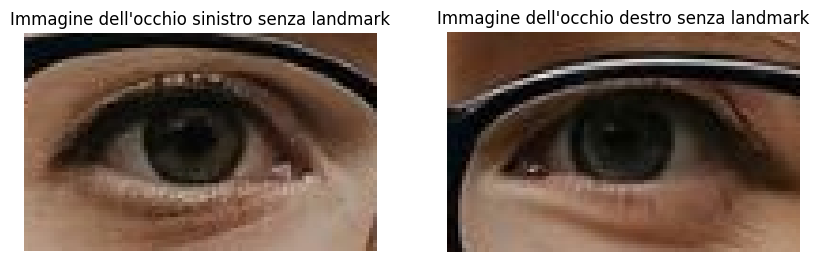

In [ ]:
image_path = '/content/drive/MyDrive/Maestria/Capstone/Test/test_img53.jpg'
output_folder_R ='/content/drive/MyDrive/Maestria/Capstone/Eyes/Testing/Right'
output_folder_L ='/content/drive/MyDrive/Maestria/Capstone/Eyes/Testing/Left'
left_eye_image, right_eye_image = eye_extraction(image_path,output_folder_R,output_folder_L)
#print(left_eye_image)
#print(right_eye_image)

if left_eye_image is not None and right_eye_image is not None:
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(left_eye_image)
    plt.title('Immagine dell\'occhio sinistro senza landmark')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(right_eye_image)
    plt.title('Immagine dell\'occhio destro senza landmark')
    plt.axis('off')

#feature1 = compute_Feature(left_eye_image)
#feature2 = compute_Feature(right_eye_image)
#mean_value = compute_mean_GLCM_values(feature1, feature2)

#print (mean_value)
